<a href="https://colab.research.google.com/github/danglive/prediction-energy-consumption/blob/master/Preprocessing_DeliveredEnergy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Exploratory data analysis and Feature Enginnering

In [0]:
# Importing libraries
import pandas as pd
# importing data from csv and converting to dataframe with datetime index
url = 'https://raw.githubusercontent.com/danglive/prediction-energy-consumption/master/EnergyConsumptionEstimation.csv'
dataset = pd.read_csv(url, error_bad_lines=False, parse_dates=True, index_col='timestamp')

In [17]:
# dataframe metadata
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4407 entries, timestamp to 2018-05-25 12:00:00
Data columns (total 5 columns):
Delivered_Energy          4407 non-null object
Travelled_Distance        4407 non-null object
Temperature_Exterieure    4407 non-null object
DriverBehaviour           4407 non-null object
DriverSex                 4407 non-null object
dtypes: object(5)
memory usage: 206.6+ KB


All columns have same length i.e. have 4407 non-null values (must still check for zeros, outliers, and other incongruencies — done in Pre-Processing notebook). Most columns are object data type except Will convert TotalConsmp to float for consistency. Index is DatetimeIndex

In [18]:
# Checking missing value
null_columns=dataset.columns[dataset.isnull().any()]
dataset[null_columns].isnull().sum()

Series([], dtype: float64)

All columns have same length i.e. have 4407 non-null values

In [19]:
dataset.head(1)

,Delivered_Energy,Travelled_Distance,Temperature_Exterieure,DriverBehaviour,DriverSex
timestamp,,,,,
timestamp,MW.h,km,Deg,DriverBehaviour,DriverSex


In [20]:
# Drop the fist line
dataset = dataset.iloc[1:]
dataset.head(2)

,Delivered_Energy,Travelled_Distance,Temperature_Exterieure,DriverBehaviour,DriverSex
timestamp,,,,,
2017-11-22 23:00:00,9.05700081620839,8.738133146835025e-06,11.3,0.2171607905520091,female
2017-11-23 00:00:00,9.05700081620839,0.0,11.2,0.24535736823806864,male


In [0]:
# converting sex column to value
dataset['DriverSex'] = dataset['DriverSex'].apply({'male':0, 'female':1}.get)

In [22]:
# visualizing the data
dataset.head(5)

,Delivered_Energy,Travelled_Distance,Temperature_Exterieure,DriverBehaviour,DriverSex
timestamp,,,,,
2017-11-22 23:00:00,9.05700081620839,8.738133146835025e-06,11.3,0.2171607905520091,1
2017-11-23 00:00:00,9.05700081620839,0.0,11.2,0.24535736823806864,0
2017-11-23 01:00:00,9.05700081620839,8.738133146835025e-06,10.8,0.06334444369720382,1
2017-11-23 02:00:00,9.05700081620839,0.0,11.3,0.9304906366876564,0
2017-11-23 03:00:00,9.05700081620839,8.738133146835025e-06,11.7,0.032536781573978324,0


In [23]:
# converting object to float64
dataset = dataset.astype(float)
dataset.describe()

,Delivered_Energy,Travelled_Distance,Temperature_Exterieure,DriverBehaviour,DriverSex
count,4406.000000,4406.000000,4406.000000,4406.000000,4406.000000
mean,13.824452,1.360924,8.011870,0.489427,0.517930
std,5.871254,3.779076,6.003686,0.291990,0.499735
min,0.000000,0.000000,-8.400000,0.000197,0.000000
25%,9.749980,0.000000,4.000000,0.233480,0.000000
50%,16.633109,0.000009,7.500000,0.485215,1.000000
75%,17.824877,0.000017,11.400000,0.745227,1.000000
max,26.063681,19.937947,28.000000,0.999860,1.000000


**Stats on Delivered Energy at different times (Monthly, Weekly, Day vs Night, Weekends vs Weekdays)**

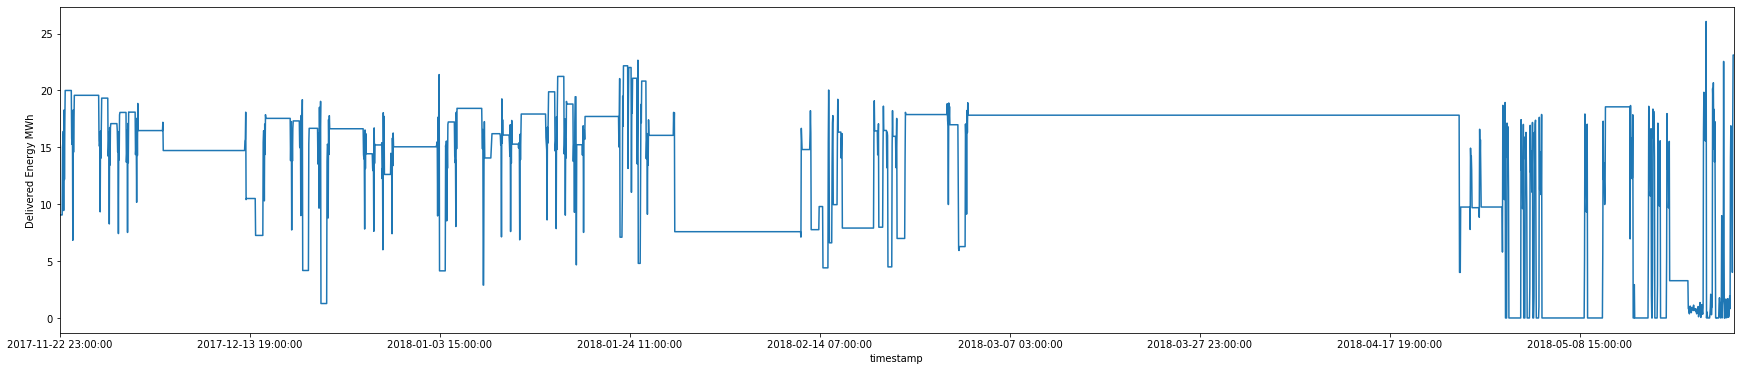

In [24]:
# Checking Delivered Energy over time, great variance.
import matplotlib.pylab as plt
Delivered_Energy = dataset["Delivered_Energy"].astype(float)
Delivered_Energy.plot(y='Delivered_Energy', figsize=(30, 6), )
plt.ylabel('Delivered Energy MWh')
plt.show()

The Delivered Energy seems to have the same form as the square-wave waveform. 

In [25]:
# Summary stats of Delivered Energy
dataset['Delivered_Energy'].describe()

count    4406.000000
mean       13.824452
std         5.871254
min         0.000000
25%         9.749980
50%        16.633109
75%        17.824877
max        26.063681
Name: Delivered_Energy, dtype: float64

In [26]:
# checking for repeated 1 hour intervals in the index. All good.
dataset.index = pd.to_datetime(dataset.index)
dataset.index[dataset.index.duplicated()].unique()

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)

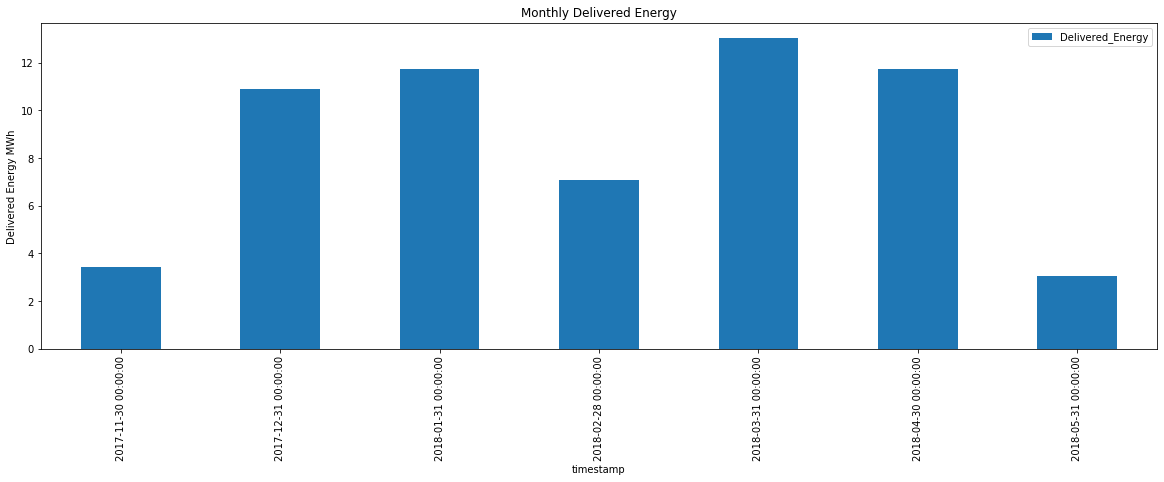

In [27]:
# Frequency was downsampled from 1 hour, to 1 month, summing each month's Delivered Energy values. 
# Data starts on 30-11-2017 and ends on 31-05-2018
monthly_Energy = pd.DataFrame(dataset['Delivered_Energy'].resample('M').sum())
monthly_Energy.divide(1000).plot(kind='bar', figsize=(20, 6))
plt.title('Monthly Delivered Energy')
plt.ylabel('Delivered Energy MWh')
plt.show()

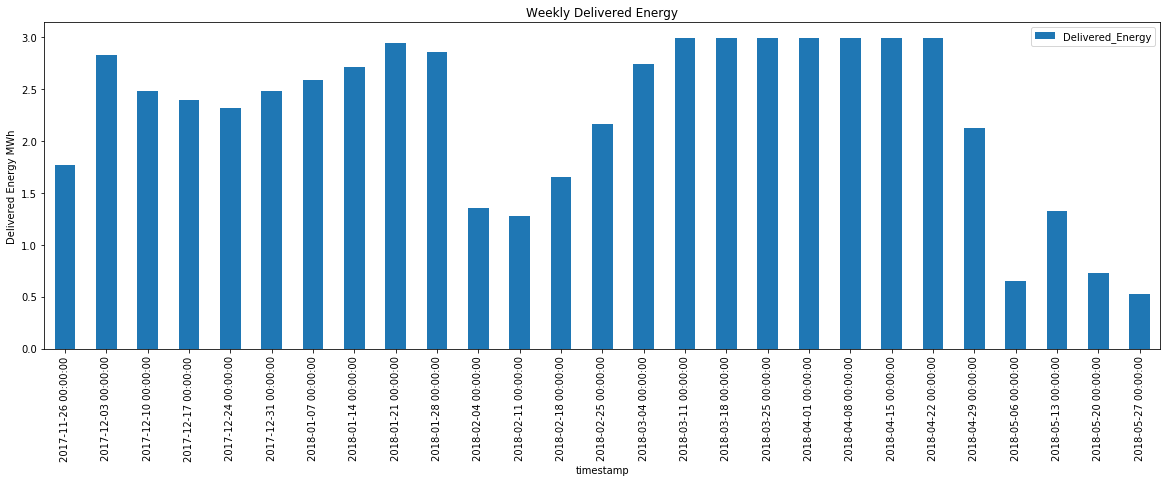

In [28]:
# Frequency was downsampled from 1 hour, to 1 week, summing each week's Delivered Energy values. 
weekly_Energy = pd.DataFrame(dataset['Delivered_Energy'].resample('W').sum())
weekly_Energy.divide(1000).plot(kind='bar', figsize=(20, 6))
plt.title('Weekly Delivered Energy')
plt.ylabel('Delivered Energy MWh')
plt.show()

In [0]:
# Defined 'Day' to be from 6:00am to 6:00pm, this can be revised later
dataset['isDay'] = False
dataset.loc[dataset.between_time('6:00', '17:59').index, 'isDay'] = True

,Delivered_Energy
isDay,
False,30143.241847
True,30767.291718


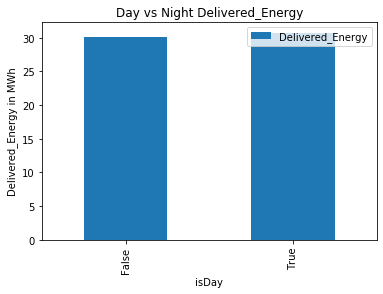

In [30]:
dataset[['Delivered_Energy', 'isDay']].groupby('isDay').sum().divide(1000).plot(kind='bar')
plt.title('Day vs Night Delivered_Energy')
plt.ylabel('Delivered_Energy in MWh')
pd.DataFrame(dataset[['Delivered_Energy', 'isDay']].groupby('isDay').sum())

We realize that Delivered Energy for day and night is the same

In [0]:
# Weekday returns the day of the week 0 = Monday, 6 = Sunday
dataset['isWeekDay'] = False
dataset.loc[dataset.index.weekday < 5, 'isWeekDay'] = True

,Delivered_Energy
isWeekDay,
False,18461.346527
True,42449.187037


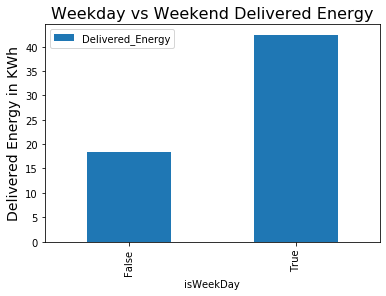

In [32]:
dataset[['Delivered_Energy', 'isWeekDay']].groupby('isWeekDay').sum().divide(1000).plot(kind='bar')
plt.title('Weekday vs Weekend Delivered Energy', fontsize=16)
plt.ylabel('Delivered Energy in KWh', fontsize=14)
pd.DataFrame(dataset[['Delivered_Energy', 'isWeekDay']].groupby('isWeekDay').sum())
# expected as there are 5 weekdays and 2 weekends

**Effect of Temperature Exterieure in Delivered Energy**

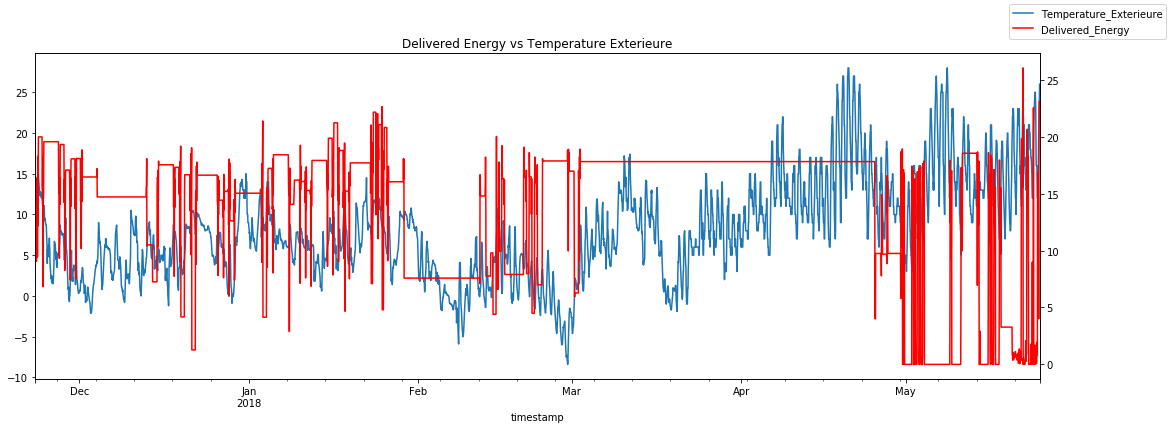

In [33]:
# Data is resampled from 1 hour intervals to hourly to improve graph clarity and load time.
ax = dataset['Temperature_Exterieure'].resample('H').mean().plot(figsize=(18,6), legend=False)
ax2 = ax.twinx()
dataset.Delivered_Energy.resample('H').sum().plot(ax=ax2, legend=False, color="r")
ax.figure.legend()
plt.title('Delivered Energy vs Temperature Exterieure')
plt.show()

In [0]:
hourly_data = dataset[['Temperature_Exterieure', 'Delivered_Energy']].resample('H').agg({'Temperature_Exterieure': 'mean', 'Delivered_Energy': 'sum'})

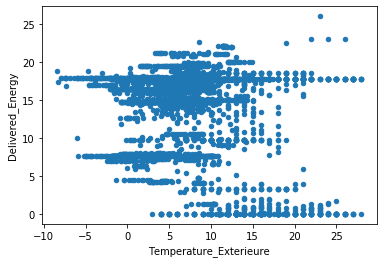

In [35]:
hourly_data.plot(x='Temperature_Exterieure', y='Delivered_Energy', kind='scatter')
plt.show()

In [36]:
dataset[['Temperature_Exterieure', 'Delivered_Energy']].corr()

,Temperature_Exterieure,Delivered_Energy
Temperature_Exterieure,1.000000,-0.154677
Delivered_Energy,-0.154677,1.000000


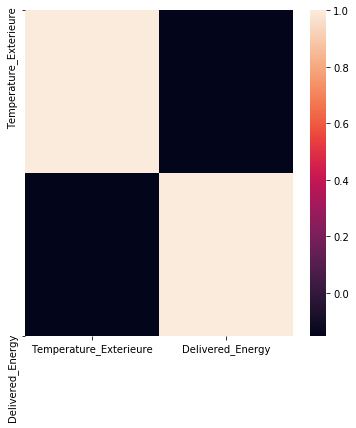

In [37]:
import seaborn as sns
corr = dataset[['Temperature_Exterieure', 'Delivered_Energy']].corr()
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(corr)
plt.show()

We observe that doesn't seem to be a strong correlation, -0.154677 Pearson.

In [0]:
# Dropping the features
userNames = ['Travelled_Distance','DriverBehaviour','DriverSex']
feature = dataset.loc[:,userNames]

In [39]:
feature.tail(3)

,Travelled_Distance,DriverBehaviour,DriverSex
timestamp,,,
2018-05-25 10:00:00,17.608687,0.432377,0.0
2018-05-25 11:00:00,0.000197,0.108709,0.0
2018-05-25 12:00:00,0.000163,0.892068,0.0


In [0]:
dataset.to_csv('data_post_preprocessing.csv')